In [2]:
# Imports
import pymssql
import pandas as pd
import numpy as np
from config import database
from config import username
from config import password
from config import server
from config import asthma_table
from config import aq_table
from config import census_table
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from joblib import dump
from sklearn.impute import SimpleImputer


In [3]:
conn = pymssql.connect(server, username, password, database)
cursor = conn.cursor()
query = f"""
    SELECT * FROM {asthma_table}
    INNER JOIN {aq_table} ON {aq_table}.AQ_ID = {asthma_table}.AQ_ID 
    WHERE {asthma_table}.YEAR != 2021
"""
df = pd.read_sql(query, conn)
print(len(df))
df.head(10)


247


,ASTHMA_ID,COUNTY_ID,YEAR,NUM_ED_VISITS,AGE_ADJ_ED_VISITS,AQ_ID,AQ_ID,COUNTY_ID,YEAR,LEAD_MEAN,...,PM25_METRIC_ID,PM25_UNITS_ID,SO2_MEAN,SO2_1STMAX,SO2_99PERC,SO2_STD,SO2_2NDMAX,SO2_METHOD_ID,SO2_METRIC_ID,SO2_UNITS_ID
0,220,862,2018,1770,38.0,767,767,862,2018,NaN,...,2,2,NaN,NaN,NaN,NaN,NaN,3,2,2
1,49,809,2015,3281,60.7,768,768,809,2015,NaN,...,2,2,NaN,NaN,NaN,NaN,NaN,3,2,2
2,119,65,2017,198,55.1,769,769,65,2017,NaN,...,2,2,NaN,NaN,NaN,NaN,NaN,3,2,2
3,236,46,2019,5910,54.2,770,770,46,2019,NaN,...,2,2,NaN,NaN,NaN,NaN,NaN,3,2,2
4,74,603,2016,487,79.4,771,771,603,2016,NaN,...,2,2,NaN,NaN,NaN,NaN,NaN,3,2,2
5,100,1737,2016,5534,29.1,772,772,1737,2016,NaN,...,2,2,0.537047,1.800000,1.60,0.381402,1.70,3,2,2
6,19,3118,2015,52227,53.1,773,773,3118,2015,0.012374,...,2,2,1.849615,21.666667,8.30,1.838851,9.70,3,2,2
7,94,2343,2016,10068,30.9,774,774,2343,2016,NaN,...,2,2,0.225350,1.200000,0.65,0.154843,0.65,3,2,2
8,147,586,2017,10076,43.2,775,775,586,2017,0.005121,...,2,2,0.617355,2.500000,1.90,0.414118,2.30,3,2,2
9,87,2491,2016,8878,29.2,776,776,2491,2016,NaN,...,2,2,0.465903,3.300000,2.10,0.496436,3.20,3,2,2


In [4]:
# Exploratory
df.drop(['ASTHMA_ID', "NUM_ED_VISITS", "COUNTY_ID", "AQ_ID", "YEAR"],
        axis=1, inplace=True, errors="ignore")
params = ["LEAD", "NO2", "OZONE", "PM10", "PM25", "SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID", f"{param}_METRIC_ID",
            f"{param}_UNITS_ID"], axis=1, inplace=True, errors="ignore")

print(df.info())
for column in df.columns:
    nan = df[df[column].isna()]
    print(column, f"{1-len(nan)/len(df):.2f}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AGE_ADJ_ED_VISITS  247 non-null    float64
 1   LEAD_MEAN          17 non-null     float64
 2   LEAD_1STMAX        17 non-null     float64
 3   LEAD_99PERC        17 non-null     float64
 4   LEAD_STD           17 non-null     float64
 5   LEAD_2NDMAX        17 non-null     float64
 6   NO2_MEAN           163 non-null    float64
 7   NO2_1STMAX         163 non-null    float64
 8   NO2_99PERC         163 non-null    float64
 9   NO2_STD            163 non-null    float64
 10  NO2_2NDMAX         163 non-null    float64
 11  OZONE_MEAN         240 non-null    float64
 12  OZONE_1STMAX       240 non-null    float64
 13  OZONE_99PERC       240 non-null    float64
 14  OZONE_STD          240 non-null    float64
 15  OZONE_2NDMAX       240 non-null    float64
 16  PM10_MEAN          15 non-

In [5]:
### Clean it
# Drop unnecessary columns
df.drop(['ASTHMA_ID', "NUM_ED_VISITS", "COUNTY_ID", "AQ_ID", "YEAR"],
        axis=1, inplace=True, errors="ignore")
params = ["LEAD", "NO2", "OZONE", "PM10", "PM25", "SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID", f"{param}_METRIC_ID",
            f"{param}_UNITS_ID"], axis=1, inplace=True, errors="ignore")

# Remove columns where at least 50% of the values are missing
df.dropna(axis=1, thresh=len(df)*0.4, inplace=True)
# print(df.columns)

# # Remove any rows that still have nulls
df.dropna(axis=0, how="any", inplace=True)

df[:]


,AGE_ADJ_ED_VISITS,NO2_MEAN,NO2_1STMAX,NO2_99PERC,NO2_STD,NO2_2NDMAX,OZONE_MEAN,OZONE_1STMAX,OZONE_99PERC,OZONE_STD,OZONE_2NDMAX,PM25_MEAN,PM25_1STMAX,PM25_99PERC,PM25_STD,PM25_2NDMAX
3,54.2,12.650939,39.325000,33.325000,7.373577,35.825000,0.041853,0.093000,0.076500,0.011707,0.086250,6.133333,25.500000,25.500000,3.794034,17.200
5,29.1,23.385278,51.650000,46.000000,9.673512,50.250000,0.044737,0.088250,0.077750,0.011794,0.082750,8.045263,22.700000,22.700000,3.834162,20.300
6,53.1,29.475561,73.842857,62.385714,12.842313,67.307143,0.054857,0.112308,0.099923,0.017255,0.105385,10.928321,51.410000,40.335000,6.861900,42.685
7,30.9,19.314232,57.666667,46.666667,10.879726,50.555556,0.050642,0.085727,0.080727,0.010884,0.082818,8.451769,23.533333,19.866667,3.427879,18.600
8,43.2,17.986095,50.114286,41.800000,9.269775,43.857143,0.060352,0.114364,0.104545,0.017974,0.111636,12.455025,46.150000,40.600000,7.090441,40.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,65.7,23.236892,61.200000,53.100000,12.087939,59.750000,0.049152,0.095500,0.086000,0.013842,0.091750,10.794251,41.050000,32.900000,6.765846,34.825
241,67.0,19.062693,55.100000,48.625000,9.693162,50.500000,0.055849,0.108800,0.098000,0.018154,0.101400,16.477120,84.025000,77.400000,15.593288,72.100
243,60.2,19.701047,47.450000,42.100000,9.399910,43.750000,0.043386,0.079250,0.072000,0.011732,0.077250,9.082204,31.150000,22.200000,4.833899,22.225
245,42.2,15.176731,51.900000,40.500000,8.251028,47.400000,0.052732,0.094750,0.082250,0.012370,0.088750,13.773410,411.700000,192.500000,32.422845,299.900


In [6]:
## Do a correlation matrix to see how it all looks
corrMatrix = df.corr()
print(corrMatrix)

                   AGE_ADJ_ED_VISITS  NO2_MEAN  NO2_1STMAX  NO2_99PERC  \
AGE_ADJ_ED_VISITS           1.000000 -0.175164   -0.197947   -0.227474   
NO2_MEAN                   -0.175164  1.000000    0.860426    0.905399   
NO2_1STMAX                 -0.197947  0.860426    1.000000    0.964342   
NO2_99PERC                 -0.227474  0.905399    0.964342    1.000000   
NO2_STD                    -0.240986  0.870115    0.884873    0.941038   
NO2_2NDMAX                 -0.212861  0.885239    0.984437    0.984116   
OZONE_MEAN                  0.124466  0.501797    0.391619    0.429308   
OZONE_1STMAX                0.223207  0.603502    0.449819    0.471176   
OZONE_99PERC                0.253471  0.573966    0.422323    0.453289   
OZONE_STD                   0.466190  0.408466    0.278440    0.305675   
OZONE_2NDMAX                0.249520  0.597815    0.448611    0.470156   
PM25_MEAN                   0.382494  0.225897    0.212884    0.232399   
PM25_1STMAX                 0.098194 -

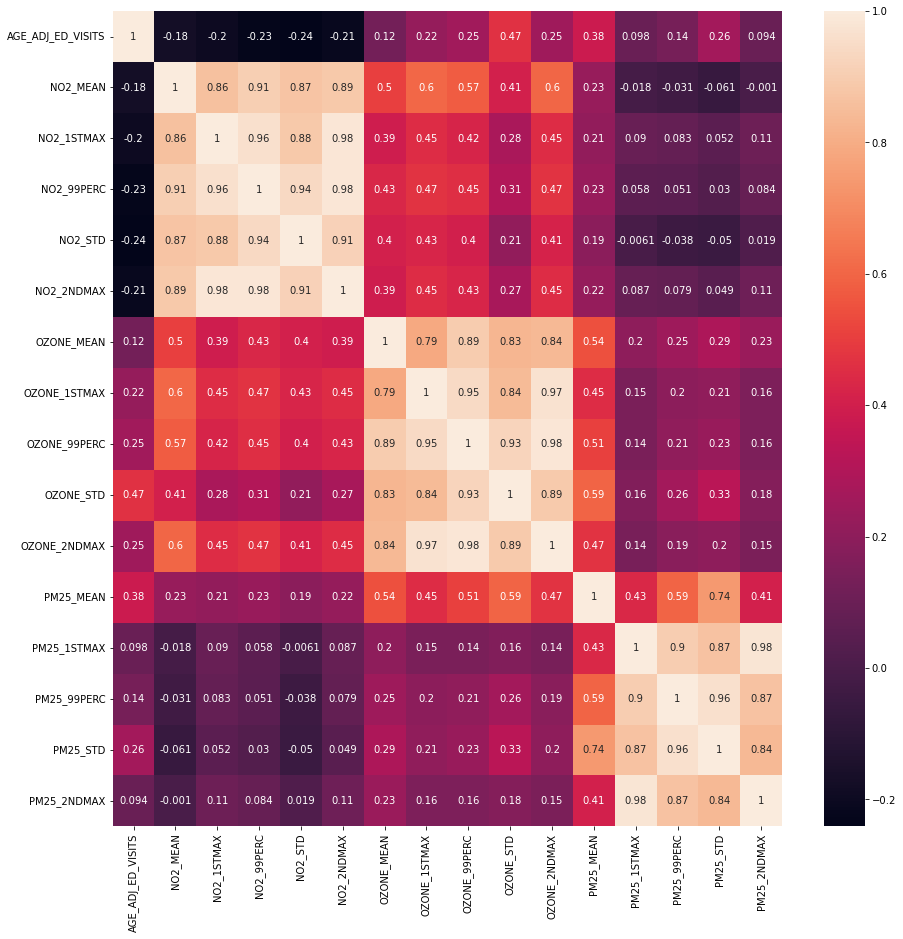

In [7]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
sn.heatmap(corrMatrix, annot=True)

plt.show()


This shows that the correlation between the different pollutants is low so we shouldn't have multicollinearity problems. 

In [8]:
### Create a training set that's 75% of your dat set and a complementary test set with the remaining 25%. Specify random_state = 0 ###
X = df.drop('AGE_ADJ_ED_VISITS', axis=1)
y = df['AGE_ADJ_ED_VISITS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)


## AdaBoost

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

ABR = AdaBoostRegressor(random_state=0, n_estimators=100)
params = {
    'n_estimators': [100, 500, 1000, 10000],
    'learning_rate': [.5, .7, 1.0, 1.2, 1.2, 1.5, 1.8, 2.0]
}
regr = GridSearchCV(
    estimator=ABR,
    param_grid=params,
    cv=5,
    n_jobs=5,
    verbose=2
)
regr.fit(X_train, y_train)
print(regr.best_params_)



Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'learning_rate': 0.7, 'n_estimators': 500}


In [10]:
# Retrain the model using just the optimized parameters
ABR = AdaBoostRegressor(random_state=0, n_estimators=500, learning_rate=0.7)
ABR.fit(X_train, y_train)
scores = cross_val_score(ABR, X_train, y_train, cv=5)
print(scores.mean())
print(f"TRAIN: {ABR.score(X_train, y_train)}")
print(f"TEST: {ABR.score(X_test, y_test)}")


0.18632162620714193
TRAIN: 0.9141665843549192
TEST: 0.3011170823441346


The marked difference between the scores on the training set and the testing set indicate that the model is highly overfit using the optimized parameters. The very low cross validation scores indicate a similar concern. 

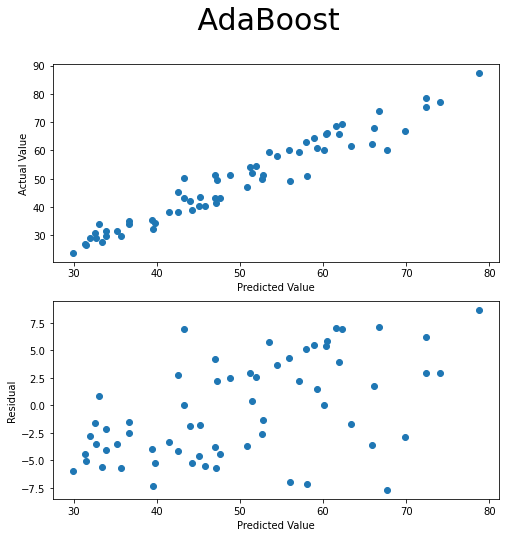

In [11]:

import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values
predict_ABR = ABR.predict(X_train)
residual_ABR = y_train - predict_ABR


figure, axis = plt.subplots(2, 1, figsize=(8, 8))
figure.suptitle(' AdaBoost ', fontsize=30)
axis[0].scatter(predict_ABR, y_train)
axis[0].set_xlabel("Predicted Value")
axis[0].set_ylabel("Actual Value")

axis[1].scatter(predict_ABR, residual_ABR)
axis[1].set_ylabel("Residual")
axis[1].set_xlabel("Predicted Value")


plt.show()



## Support Vector Regression
This method works well to fit non-linear relationships. Tuning can be done on the type of models as well as other hyper-parameters. 

In [12]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

print("RBF")
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_rbf.fit(X_train, y_train)
scores = cross_val_score(svr_rbf, X_train, y_train, cv=5)
print(scores.mean())
print(f"TRAIN: {svr_rbf.score(X_train, y_train)}")
print(f"TEST: {svr_rbf.score(X_test, y_test)}")

print("Linear")
svr_linear = SVR(kernel="linear", C=100, gamma="auto")
svr_linear.fit(X_train, y_train)
scores = cross_val_score(svr_linear, X_train, y_train, cv=5)
print(scores.mean())
print(f"TRAIN: {svr_linear.score(X_train, y_train)}")
print(f"TEST: {svr_linear.score(X_test, y_test)}")

print("Polynomial")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
svr_poly.fit(X_train, y_train)
scores = cross_val_score(svr_poly, X_train, y_train, cv=5)
print(scores.mean())
print(f"TRAIN: {svr_poly.score(X_train, y_train)}")
print(f"TEST: {svr_poly.score(X_test, y_test)}")


RBF
-0.05752802962757379
TRAIN: 0.9999580425499024
TEST: 0.006969294584541985
Linear
-0.8632926996888219
TRAIN: 0.2370851757101724
TEST: -0.15861652057057607
Polynomial
-128884.95098888103
TRAIN: 0.449176165738022
TEST: -88.87378440725774


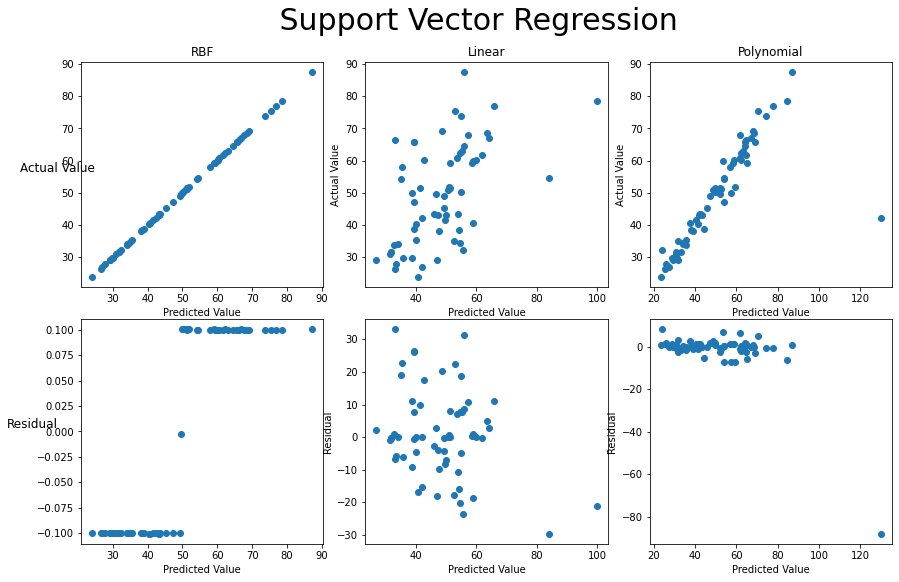

In [13]:
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values
predict_svr_rbf = svr_rbf.predict(X_train)
residual_svr_rbf = y_train - predict_svr_rbf

predict_svr_linear = svr_linear.predict(X_train)
residual_svr_linear = y_train - predict_svr_linear

predict_svr_poly = svr_poly.predict(X_train)
residual_svr_poly = y_train - predict_svr_poly

cols = ['RBF', 'Linear', 'Polynomial']
rows = ['','']

figure, axis = plt.subplots(2, 3, figsize=(12, 8))
figure.suptitle(' Support Vector Regression ', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

for ax, row in zip(axis[:, 0], rows):
    ax.set_ylabel(row, rotation=0, size='large')

figure.tight_layout()

axis[0,0].scatter(predict_svr_rbf, y_train)
axis[0,0].set_xlabel("Predicted Value")
axis[0,0].set_ylabel("Actual Value")

axis[1,0].scatter(predict_svr_rbf, residual_svr_rbf)
axis[1,0].set_ylabel("Residual")
axis[1,0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_linear, y_train)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_linear, residual_svr_linear)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

axis[0, 2].scatter(predict_svr_poly, y_train)
axis[0, 2].set_xlabel("Predicted Value")
axis[0, 2].set_ylabel("Actual Value")

axis[1, 2].scatter(predict_svr_poly, residual_svr_poly)
axis[1, 2].set_ylabel("Residual")
axis[1, 2].set_xlabel("Predicted Value")
plt.show()



## Voting Regressor
Take the pretty poor regressors that we developed above and use them together in an ensemble to improve their functionality.

In [14]:
from sklearn.ensemble import VotingRegressor

ereg = VotingRegressor(
    estimators=[('ABR', ABR), ('svr_rbf', svr_rbf), ('svr_linear', svr_linear), ('svr_poly', svr_poly)])
ereg = ereg.fit(X_train, y_train)
scores = cross_val_score(ereg, X_train, y_train, cv=5)
print(scores.mean())
print(f"TRAIN: {ereg.score(X_train, y_train)}")
print(f"TEST: {ereg.score(X_test, y_test)}")


-8016.750963784238
TRAIN: 0.8952340469107062
TEST: -4.991563573231831


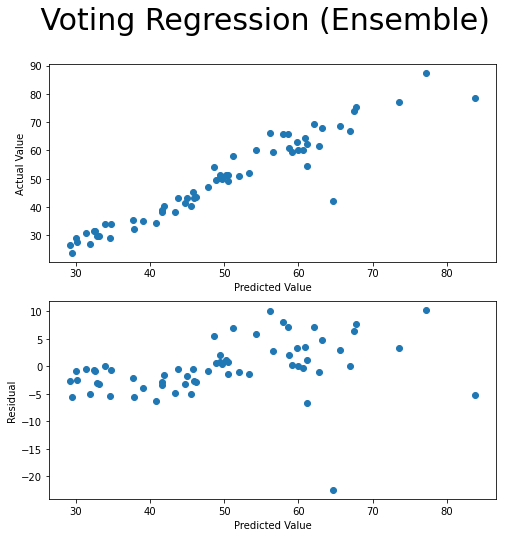

In [15]:
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values
predict_ereg = ereg.predict(X_train)
residual_ereg = y_train - predict_ereg


figure, axis = plt.subplots(2, 1, figsize=(8, 8))
figure.suptitle(' Voting Regression (Ensemble) ', fontsize=30)
axis[0].scatter(predict_ereg, y_train)
axis[0].set_xlabel("Predicted Value")
axis[0].set_ylabel("Actual Value")

axis[1].scatter(predict_ereg, residual_ereg)
axis[1].set_ylabel("Residual")
axis[1].set_xlabel("Predicted Value")


plt.show()


## Plot all of them together for training and test sets

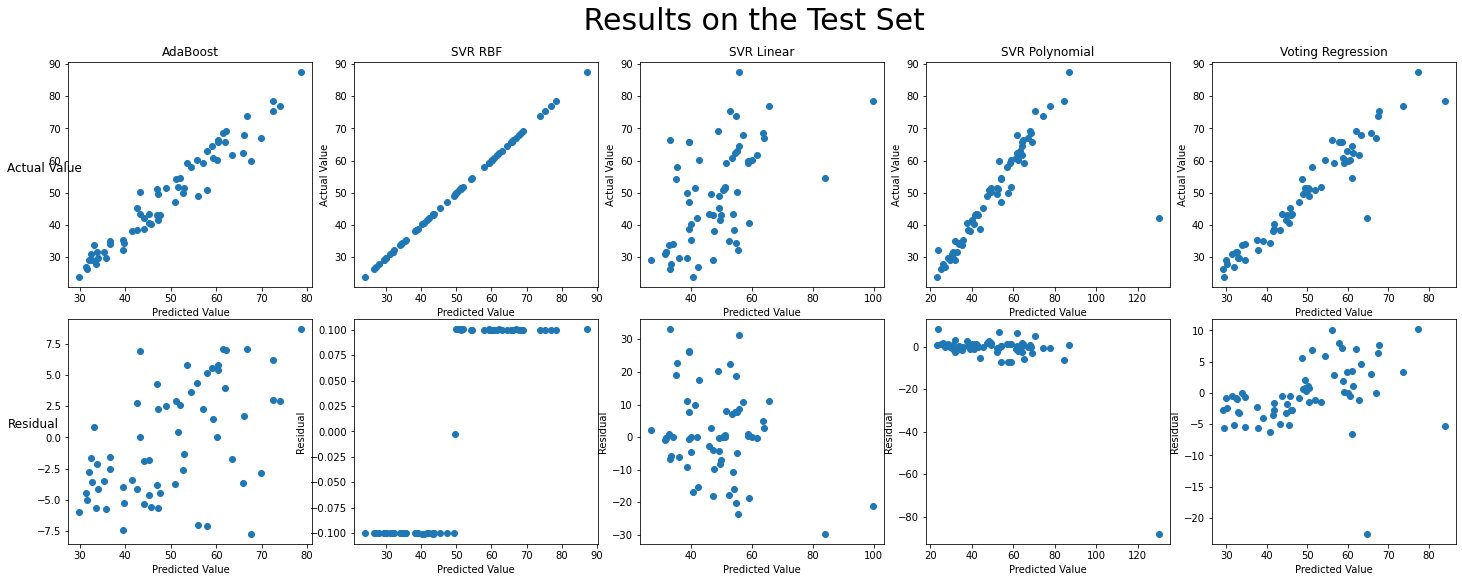

In [25]:
# checking all of them together against the testing set
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values

predict_ABR = ABR.predict(X_train)
residual_ABR = y_train - predict_ABR

predict_svr_rbf = svr_rbf.predict(X_train)
residual_svr_rbf = y_train - predict_svr_rbf

predict_svr_linear = svr_linear.predict(X_train)
residual_svr_linear = y_train - predict_svr_linear

predict_svr_poly = svr_poly.predict(X_train)
residual_svr_poly = y_train - predict_svr_poly

predict_ereg = ereg.predict(X_train)
residual_ereg = y_train - predict_ereg

cols = ['AdaBoost', 'SVR RBF', 'SVR Linear', 'SVR Polynomial', 'Voting Regression']
rows = ['', '']

figure, axis = plt.subplots(2, 5, figsize=(20, 8))
figure.suptitle(' Results on the Training Set ', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

for ax, row in zip(axis[:, 0], rows):
    ax.set_ylabel(row, rotation=0, size='large')

figure.tight_layout()


axis[0, 0].scatter(predict_ABR, y_train)
axis[0, 0].set_xlabel("Predicted Value")
axis[0, 0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_ABR, residual_ABR)
axis[1, 0].set_ylabel("Residual")
axis[1, 0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_rbf, y_train)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_rbf, residual_svr_rbf)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

axis[0, 2].scatter(predict_svr_linear, y_train)
axis[0, 2].set_xlabel("Predicted Value")
axis[0, 2].set_ylabel("Actual Value")

axis[1, 2].scatter(predict_svr_linear, residual_svr_linear)
axis[1, 2].set_ylabel("Residual")
axis[1, 2].set_xlabel("Predicted Value")

axis[0, 3].scatter(predict_svr_poly, y_train)
axis[0, 3].set_xlabel("Predicted Value")
axis[0, 3].set_ylabel("Actual Value")

axis[1, 3].scatter(predict_svr_poly, residual_svr_poly)
axis[1, 3].set_ylabel("Residual")
axis[1, 3].set_xlabel("Predicted Value")

axis[0, 4].scatter(predict_ereg, y_train)
axis[0, 4].set_xlabel("Predicted Value")
axis[0, 4].set_ylabel("Actual Value")

axis[1, 4].scatter(predict_ereg, residual_ereg)
axis[1, 4].set_ylabel("Residual")
axis[1, 4].set_xlabel("Predicted Value")


plt.show()


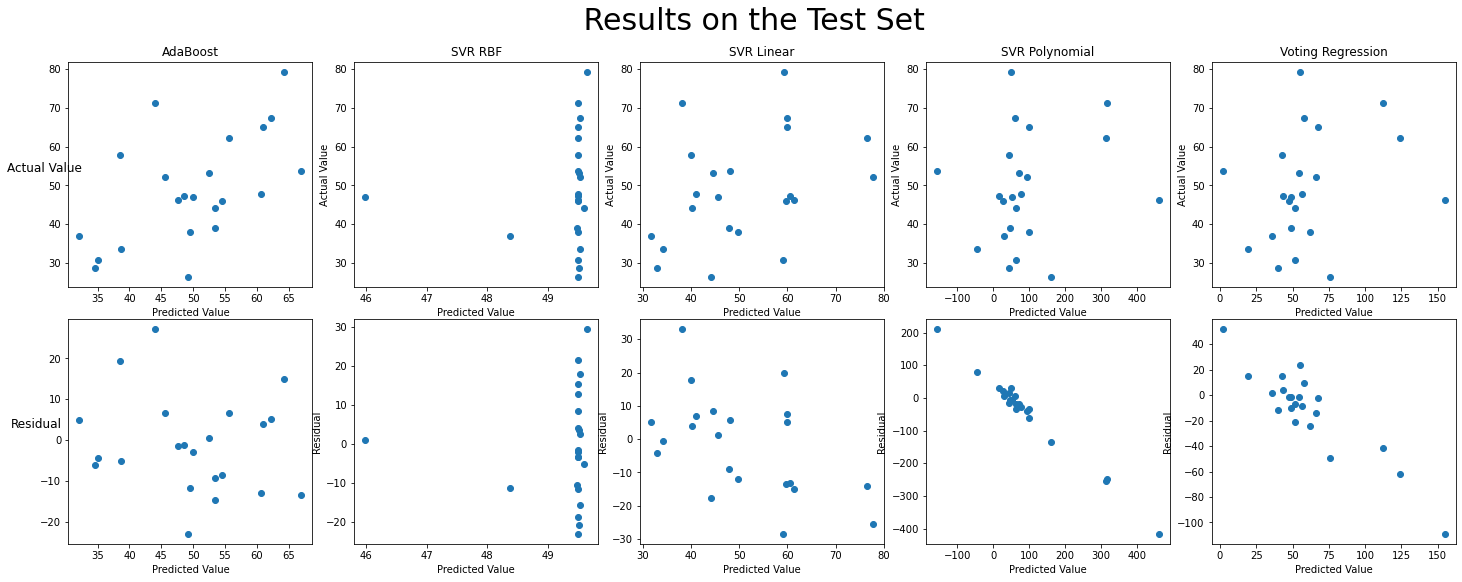

In [24]:
# checking all of them together against the testing set
import matplotlib.pyplot as plt
# Plot the predicted versus actual values and the residual versus predicted values

predict_ABR = ABR.predict(X_test)
residual_ABR = y_test - predict_ABR

predict_svr_rbf = svr_rbf.predict(X_test)
residual_svr_rbf = y_test - predict_svr_rbf

predict_svr_linear = svr_linear.predict(X_test)
residual_svr_linear = y_test - predict_svr_linear

predict_svr_poly = svr_poly.predict(X_test)
residual_svr_poly = y_test - predict_svr_poly

predict_ereg = ereg.predict(X_test)
residual_ereg = y_test - predict_ereg

cols = ['AdaBoost', 'SVR RBF', 'SVR Linear', 'SVR Polynomial', 'Voting Regression']
rows = ['', '']

figure, axis = plt.subplots(2, 5, figsize=(20, 8))
figure.suptitle(' Results on the Test Set ', fontsize=30)

for ax, col in zip(axis[0], cols):
    ax.set_title(col)

for ax, row in zip(axis[:, 0], rows):
    ax.set_ylabel(row, rotation=0, size='large')

figure.tight_layout()


axis[0, 0].scatter(predict_ABR, y_test)
axis[0, 0].set_xlabel("Predicted Value")
axis[0, 0].set_ylabel("Actual Value")

axis[1, 0].scatter(predict_ABR, residual_ABR)
axis[1, 0].set_ylabel("Residual")
axis[1, 0].set_xlabel("Predicted Value")

axis[0, 1].scatter(predict_svr_rbf, y_test)
axis[0, 1].set_xlabel("Predicted Value")
axis[0, 1].set_ylabel("Actual Value")

axis[1, 1].scatter(predict_svr_rbf, residual_svr_rbf)
axis[1, 1].set_ylabel("Residual")
axis[1, 1].set_xlabel("Predicted Value")

axis[0, 2].scatter(predict_svr_linear, y_test)
axis[0, 2].set_xlabel("Predicted Value")
axis[0, 2].set_ylabel("Actual Value")

axis[1, 2].scatter(predict_svr_linear, residual_svr_linear)
axis[1, 2].set_ylabel("Residual")
axis[1, 2].set_xlabel("Predicted Value")

axis[0, 3].scatter(predict_svr_poly, y_test)
axis[0, 3].set_xlabel("Predicted Value")
axis[0, 3].set_ylabel("Actual Value")

axis[1, 3].scatter(predict_svr_poly, residual_svr_poly)
axis[1, 3].set_ylabel("Residual")
axis[1, 3].set_xlabel("Predicted Value")

axis[0, 4].scatter(predict_ereg, y_test)
axis[0, 4].set_xlabel("Predicted Value")
axis[0, 4].set_ylabel("Actual Value")

axis[1, 4].scatter(predict_ereg, residual_ereg)
axis[1, 4].set_ylabel("Residual")
axis[1, 4].set_xlabel("Predicted Value")


plt.show()
